In [2]:
import numpy as np
from keras.losses import SparseCategoricalCrossentropy
import os 
import tempfile
from keras.models import load_model, save_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf
import Neural_Network_Tools.tools as nnt

NUM_OF_CLASSES = 3

In [3]:
(train_data, train_labels),(test_data, test_labels) = nnt.prepare_train_test_dataset()

In [4]:
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def weight_pruning(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):
    
  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(
  test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  # Compute end step to finish pruning after 2 epochs.
  validation_split = 0.1 # 10% of training set will be used for validation set. 

  num_training_samples = train_data.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_training_samples/batch_size).astype(np.int32) * epochs

  # Define model for pruning.
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                                final_sparsity=0.8,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(new_model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # model_for_pruning.summary()

  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  pruned_model_history = model_for_pruning.fit(train_data, train_labels, batch_size = 128, epochs=epochs, validation_split=validation_split,
                    callbacks=callbacks)
  
  nnt.plot_history(pruned_model_history, epochs, os.path.join(store_path,"history_pruned_fnn_model"))

  _, model_for_pruning_accuracy = model_for_pruning.evaluate(test_data, test_labels, verbose=0)

  print('Baseline model  test accuracy:', baseline_model_accuracy) 
  print('Pruned model test accuracy:', model_for_pruning_accuracy)

  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

  pruned_keras_file = os.path.join(store_path,"pruned_model.h5")
  save_model(model_for_export, pruned_keras_file, include_optimizer=False)
  print('Saved pruned model to:', pruned_keras_file)

  converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
  pruned_tflite_model = converter.convert()

  pruned_tflite_file = os.path.join(store_path, "pruned_tflite_model.tflite")

  with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

  print('Saved pruned TFLite model to:', pruned_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(keras_file)))
  print("Size of gzipped pruned Keras model: %.2f bytes" % (nnt.get_gzipped_model_size(pruned_keras_file)))
  print("Size of gzipped pruned TFlite model: %.2f bytes" % (nnt.get_gzipped_model_size(pruned_tflite_file)))


Original model test accuracy: 0.9941359758377075
Saved baseline model to: Pruning\baseline_model.h5
Epoch 1/8
542/542 [==============================] - 6s 3ms/step - loss: 0.0779 - accuracy: 0.9771 - val_loss: 0.0193 - val_accuracy: 0.9938
Epoch 2/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0827 - accuracy: 0.9745 - val_loss: 0.0284 - val_accuracy: 0.9865
Epoch 3/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0644 - accuracy: 0.9789 - val_loss: 0.0927 - val_accuracy: 0.9667
Epoch 4/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0530 - accuracy: 0.9803 - val_loss: 0.0235 - val_accuracy: 0.9921
Epoch 5/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0420 - accuracy: 0.9867 - val_loss: 0.0315 - val_accuracy: 0.9904
Epoch 6/8
542/542 [==============================] - 2s 3ms/step - loss: 0.0312 - accuracy: 0.9893 - val_loss: 0.0156 - val_accuracy: 0.9944
Epoch 7/8
542/542 [==============================] - 2

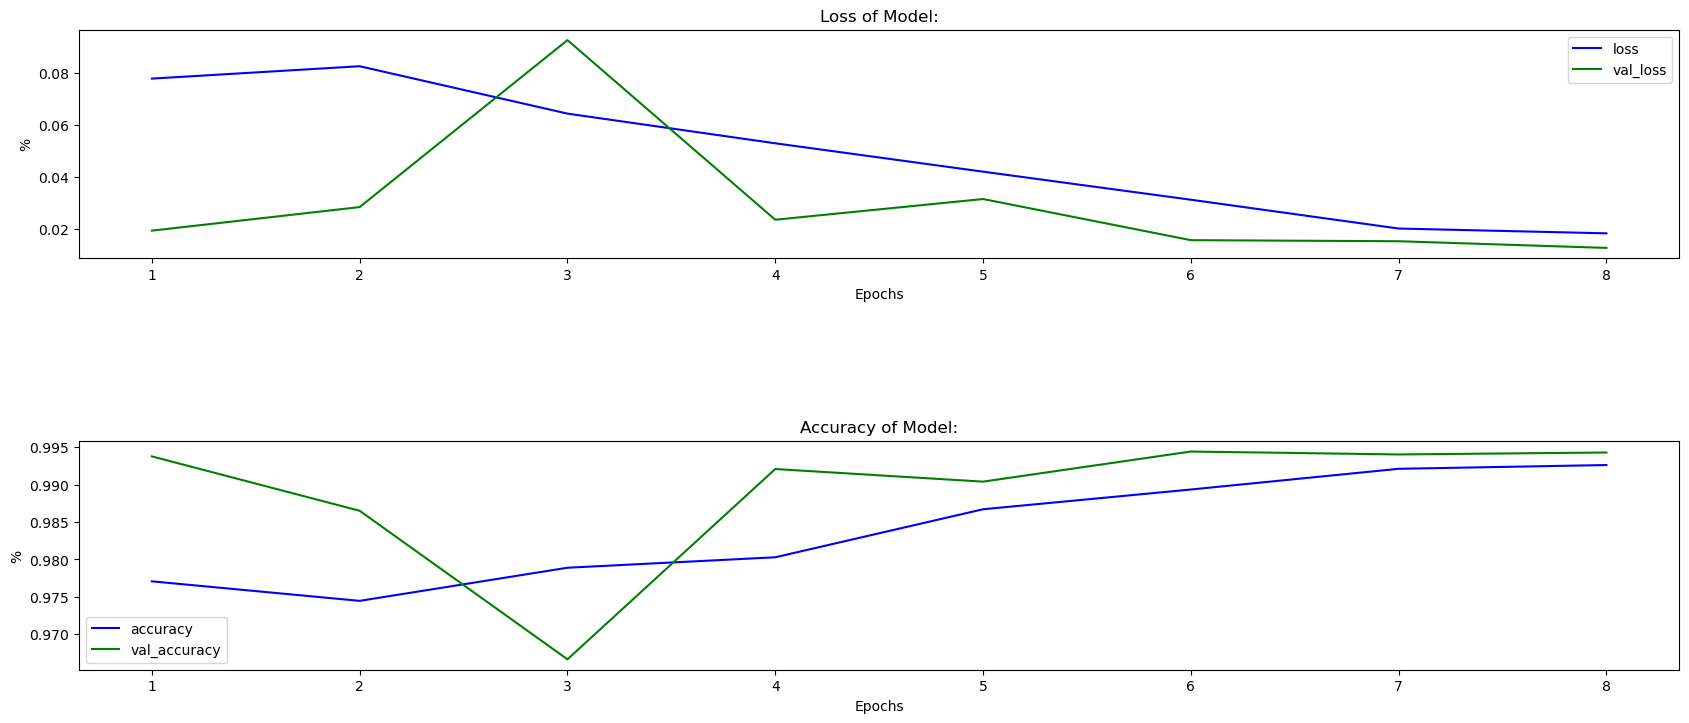

Baseline model  test accuracy: 0.9941359758377075
Pruned model test accuracy: 0.9926310181617737
Saved pruned model to: Pruning\pruned_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpf5cf2122\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpf5cf2122\assets


Saved pruned TFLite model to: Pruning\pruned_tflite_model.tflite
Size of gzipped baseline Keras model: 290002.00 bytes
Size of gzipped pruned Keras model: 95381.00 bytes
Size of gzipped pruned TFlite model: 93743.00 bytes


In [5]:
weight_pruning("fnn_model.h5", train_data, train_labels, test_data, test_labels, batch_size=128, epochs=8, store_path="Pruning")